In [27]:
# !wget https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
# !unzip data_gsn.zip &> /dev/null
# !rm data_gsn.zip

In [28]:
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import pandas as pd
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from torch import Tensor
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)


In [29]:
class GSN(Dataset):
    def __init__(self, root, transform=None):
        self.data_dir = os.path.join(root, "data")
        self.transform = transform

        df = pd.read_csv(os.path.join(self.data_dir, "labels.csv"))
        self.names = df["name"].tolist()
        cols = ["squares", "circles", "up", "right", "down", "left"]
        self.labels = torch.tensor(df[cols].values, dtype=torch.float32)

    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, index):
        name = self.names[index]
        img_path = os.path.join(self.data_dir, name)

        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)
        
        cnt = self.labels[index]
        cls = self.counts_to_class_id(cnt)

        return img, cls, cnt
    
    def counts_to_class_id(self, counts):
        PAIRS = [(i, j) for i in range(6) for j in range(i + 1, 6)]
        if isinstance(counts, torch.Tensor):
            c = counts.detach().cpu().tolist()
        else:
            c = list(counts)

        nz = [i for i, v in enumerate(c) if v > 0]
        if len(nz) != 2:
            raise ValueError(f"Expected exactly 2 nonzero counts, got {len(nz)}: {c}")
        if sum(c) != 10:
            raise ValueError(f"Expected counts to sum to 10, got {sum(c)}: {c}")

        a, b = sorted(nz)
        ca = int(c[a])
        pair_index = PAIRS.index((a, b))

        class_id = pair_index * 9 + (ca - 1)
        return class_id


In [30]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = nn.Sequential(                              # (64, 1, 28, 28)
            nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),     # (64, 8, 28 28)  
            nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),    # (64, 16, 28, 28)
            nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),   # (64, 32, 28, 28)
            nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),   # (64, 64, 28, 28)
            nn.Flatten(start_dim=1),                                # (64, 64 * 28 * 28)
            nn.Linear(64 * 28 * 28, 256), nn.ReLU()
        )

        self.head_cls = nn.Sequential(
            nn.Linear(256, 135),
            nn.LogSoftmax(dim=1)
        )

        self.head_cnt = nn.Sequential(
            nn.Linear(256, 6)
        )
    
    def forward(self, x):
        x = self.backbone(x)

        cls = self.head_cls(x)  # (64, 135)
        cnt = self.head_cnt(x)  # (64, 6)

        return cls, cnt

In [41]:
def train_epoch(
    net: torch.nn.Module,
    device: torch.device,
    train_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    log_interval: int,
    lambda_cnt: float,
    verbose: bool = False,
) -> None:
    net.train()
    total_loss = 0.0
    total_cls_loss = 0.0
    total_cnt_loss = 0.0
    n_total = 0
    
    for batch_idx, (img, cls_target, cnt_target) in enumerate(train_loader):
        img, cls_target, cnt_target = img.to(device), cls_target.long().to(device), cnt_target.to(device)

        optimizer.zero_grad()

        cls_pred, cnt_pred = net(img)
        
        cls_loss = F.nll_loss(cls_pred, cls_target)
        cnt_loss = F.smooth_l1_loss(cnt_pred, cnt_target)
        loss = cls_loss + lambda_cnt * cnt_loss

        loss.backward()
        optimizer.step()

        B = len(img)

        total_loss += loss.item() * B
        total_cls_loss += cls_loss.item() * B
        total_cnt_loss += cnt_loss.item() * B
        n_total += B

        if verbose and batch_idx % log_interval == 0:
            done = batch_idx * B
            total = len(train_loader.dataset)
            print(
                f"Train Epoch: {epoch} [{done}/{total} images ({done / total:.0%})]\t"
                + f"Loss: {loss.item():.6f}"
            )

    epoch_loss = total_loss / n_total
    epoch_cls_loss = total_cls_loss / n_total
    epoch_cnt_loss = total_cnt_loss / n_total
    return epoch_loss, epoch_cls_loss, epoch_cnt_loss


In [73]:
def eval_epoch(
    net: torch.nn.Module,
    device: torch.device,
    test_loader: torch.utils.data.DataLoader,
    epoch: int,
    lambda_cnt: float,
    verbose: bool = False,
):
    net.eval()
    total_loss = 0.0
    total_cls_loss = 0.0
    total_cnt_loss = 0.0
    n_total = 0
    correct = 0


    with torch.no_grad():
        for img, cls_target, cnt_target in test_loader:
            img, cls_target, cnt_target = img.to(device), cls_target.long().to(device), cnt_target.to(device)

            cls_pred, cnt_pred = net(img)
            cls_loss = F.nll_loss(cls_pred, cls_target)
            cnt_loss = F.smooth_l1_loss(cnt_pred, cnt_target)
            loss = cls_loss + lambda_cnt * cnt_loss

            total_loss += loss.item() * len(img)
            total_cls_loss += cls_loss.item() * len(img)
            total_cnt_loss += cnt_loss.item() * len(img)
            n_total += len(img)

            pred = cls_pred.argmax(dim=1)
            correct += (pred == cls_target).sum().item()

    epoch_loss = total_loss / n_total
    epoch_cls_loss = total_cls_loss / n_total
    epoch_cnt_loss = total_cnt_loss / n_total
    epoch_acc = correct / n_total

    if verbose:
        print(f"Eval Epoch: {epoch} accuracy: {epoch_acc:.4f} epoch_loss: {epoch_loss:.4f} epoch_cls_loss: {epoch_cls_loss:.4f} epoch_cnt_loss: {epoch_cnt_loss:.4f}\n")
    return epoch_loss, epoch_cls_loss, epoch_cnt_loss, epoch_acc

In [75]:
epochs = 15
lr = 1e-3
log_interval = 10
batch_size = 64
test_batch_size = 1000
lambda_cnt = 0.0
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

transform = transforms.Compose(
    [transforms.ToTensor()]
)

full_dataset = GSN(root=".", transform=transform)

train_dataset = Subset(full_dataset, range(0,9000))
test_dataset = Subset(full_dataset, range(9000, 10000))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

net = NeuralNetwork().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

train_losses = []
eval_losses = []

best_eval_loss = float("inf")
best_state = None
bad_epochs = 0
bad_epochs_patience = 4
optimal_epochs = epochs

for epoch in range(1, epochs+1):
    train_loss, train_cls_loss, train_cnt_loss = train_epoch(
        net,
        device,
        train_loader,
        optimizer,
        epoch,
        log_interval,
        lambda_cnt,
        verbose=False
    )

    eval_loss, eval_cls_loss, eval_cnt_loss, eval_acc = eval_epoch(
        net,
        device,
        test_loader,
        epoch,
        lambda_cnt,
        verbose=True
    )

    if eval_loss < best_eval_loss - 1e-4:
        best_eval_loss = eval_loss
        best_state = {k: v.cpu().clone() for k,v in net.state_dict().items()}
        bad_epochs = 0
        optimal_epochs = epoch
    else:
        bad_epochs += 1
        if bad_epochs >= bad_epochs_patience:
            print(f"Early stop at epoch {epoch}. Best eval loss: {best_eval_loss:.4f}, Optimal epochs: {optimal_epochs}")
            break
    
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)

if best_state is not None:
    net.load_state_dict(best_state)


Eval Epoch: 1 accuracy: 0.0150 epoch_loss: 4.5437 epoch_cls_loss: 4.5437 epoch_cnt_loss: 1.5471

Eval Epoch: 2 accuracy: 0.1120 epoch_loss: 3.2903 epoch_cls_loss: 3.2903 epoch_cnt_loss: 2.1032

Eval Epoch: 3 accuracy: 0.1700 epoch_loss: 2.8306 epoch_cls_loss: 2.8306 epoch_cnt_loss: 2.3734

Eval Epoch: 4 accuracy: 0.1930 epoch_loss: 2.5492 epoch_cls_loss: 2.5492 epoch_cnt_loss: 2.5071

Eval Epoch: 5 accuracy: 0.1830 epoch_loss: 2.8057 epoch_cls_loss: 2.8057 epoch_cnt_loss: 2.8735

Eval Epoch: 6 accuracy: 0.2170 epoch_loss: 3.0195 epoch_cls_loss: 3.0195 epoch_cnt_loss: 3.2654

Eval Epoch: 7 accuracy: 0.1830 epoch_loss: 4.0111 epoch_cls_loss: 4.0111 epoch_cnt_loss: 4.1672

Eval Epoch: 8 accuracy: 0.1970 epoch_loss: 4.6649 epoch_cls_loss: 4.6649 epoch_cnt_loss: 4.7573

Early stop at epoch 8. Best eval loss: 2.5492, Optimal epochs: 4


In [69]:
train_losses

[5.112630518171522,
 4.004650132921007,
 2.600361385769314,
 1.8549076976776122,
 1.3285546663072374]

In [70]:
eval_losses

[4.857315540313721,
 3.335753917694092,
 2.7865426540374756,
 2.6822454929351807,
 2.772702693939209]

In [ ]:
save_path = "first_net.pt"
torch.save(net.state_dict(), "first_net.pt")

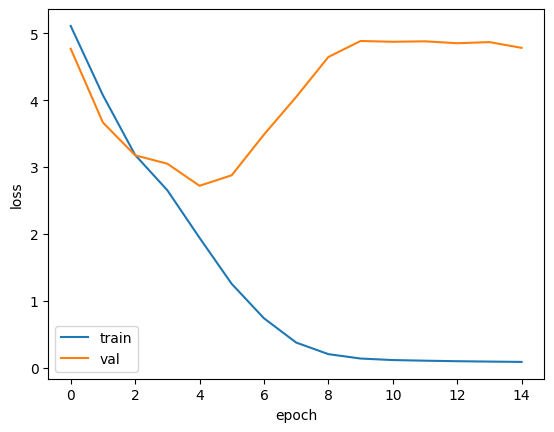

In [51]:
plt.plot(train_losses, label="train")
plt.plot(eval_losses, label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


In [36]:
net2 = NeuralNetwork().to(device)
# net2.load_state_dict(torch.load(save_path, map_location=device))

with torch.no_grad():
    net2.eval()
    img, cnt, cls = train_dataset[50]
    img = img.to(device)
    print(img.size(0))
    print(len(img))
    # cls_pred, cnt_pred = net2(img.unsqueeze(0))

# print(cnt)
# print(cls)
# print(cls_pred.argmax().item())
# print(cnt_pred.round())
    

1
1


In [37]:
for img, cls_target, cnt_target in test_loader:
    img, cls_target, cnt_target = img.to(device), cls_target.long().to(device), cnt_target.to(device)
    print(img.shape)
    print(img.size(0))
    print(len(img))
    break

torch.Size([1000, 1, 28, 28])
1000
1000


torch.Size([1, 28, 28])
93


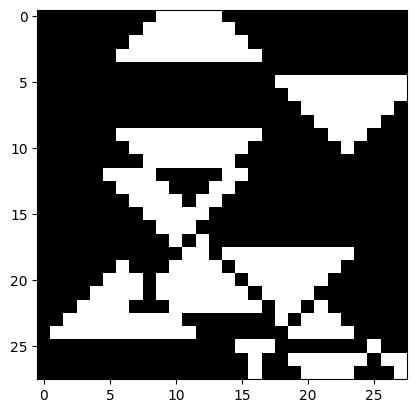

In [38]:
img, cnt, class_id = train_dataset[0]
print(img.shape)
print(cnt)
class_id
plt.imshow(img.squeeze(0), cmap='gray')